
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 1. Load and normalizing CIFAR10 dataset.
The output of torchvision datasets are PILImage images of range [0, 1].
Use `transforms.ToTensor()` to convert the input image into a tensor and reshape the dimensions of the image from(height, width, channel) to (channel, height, width).  
Than `transforms.Normalize()` can normalize our input tensor to mean 0.5 and standard deviation 0.5.。
> `transforms.Normalize((mean), (std)) = (input - mean) / std`


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# you can try other transforms, e.g. add random flip, random crop or etc to augment your data.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# transet is an iterable object, you can use for loop to access the data or get any data use 'trainset[<int>]'.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
# trainloader is an dataloader object from pytorch, you can use for loop to access the data,
# or use next(iter(trainloader)) to get a batch of data.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48028235.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



 deer  ship horse   dog


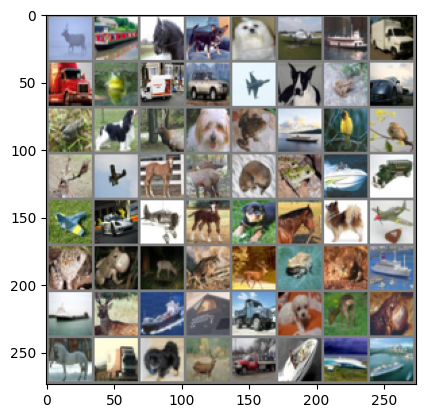

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Using GPU or other accelerator to Training.

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: CPU
************************************************** 
[WARNING] You may need to change the device to GPU or MPS to get better performance.
**************************************************


# 2. Define a Convolution Neural Network  
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^  
Define some convolution blocks "nn.Conv2d()" to build our CNN net work, you can try to modify the args to see what happends.  
And here is the basic args:  
> `nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)`
>
The argument "in_channels" must match your input tensor's "C". (input_tensor.shape = (batch, C, H, W))  
The output shape of your tensor can be caculate with function:  
> `output_H_or_W = ` $\lfloor$ `(input_H_or_W + 2*padding - kernelsize) / stride ` $\rfloor$
>  

After the CNN net work, we use fully connection layer "nn.Linear()" to bulid the classification net work.  
Here is the basic args:  
> ` nn.Linear(in_channels, out_channels) `
>
The input channel of linear layer "in_channels" must match the output shape of the last Convolution layer.  
> `1st_linear_in_channels = last_Conv_C * last_Conv_H * last_Conv_W`
>
And the output of the last linear layer must match the number of classes "10".

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # you can try other module like dropout, batch normalization, etc to improve model.
        # And other activation function like sigmoid, tanh, etc.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

# 3. Define a Loss function and optimizer  
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^  
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# you can try other optimizer like Adam, RMSprop, etc.

# 4. Train the network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^  
This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
EPOCHS = 10 # you can try more epochs number to get better performance.
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs, and use .to(device) to move your data to accelerator.
        inputs, labels = data[0].to(device), data[1].to(device)

        # Eliminate previous gradients to avoid gradients accumulation.
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i == 0:
          print(f"\nEpoch:{epoch+1}")
        print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end='')

print('\nFinished Training')


Epoch:1
	Batch:782 of 782, loss:2.290
Epoch:2
	Batch:782 of 782, loss:2.017
Epoch:3
	Batch:782 of 782, loss:1.761
Epoch:4
	Batch:782 of 782, loss:1.537
Epoch:5
	Batch:782 of 782, loss:1.337
Epoch:6
	Batch:782 of 782, loss:1.305
Epoch:7
	Batch:782 of 782, loss:1.093
Epoch:8
	Batch:782 of 782, loss:1.257
Epoch:9
	Batch:782 of 782, loss:1.074
Epoch:10
	Batch:782 of 782, loss:1.394
Finished Training


# 5. Test the network on the test data  
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^  

We have trained the network for 10 passes over the training dataset.  
But we need to check if the network has learnt anything at all.  

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.  

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


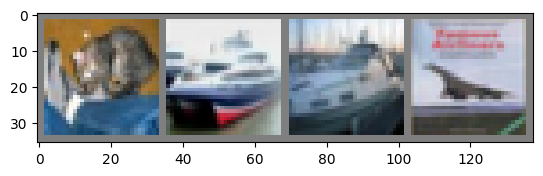

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
net.eval()
with torch.no_grad():
  outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
preds = np.zeros((1))
truth = np.zeros((1))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 66 %
Accuracy of  bird : 22 %
Accuracy of   cat : 30 %
Accuracy of  deer : 38 %
Accuracy of   dog : 50 %
Accuracy of  frog : 55 %
Accuracy of horse : 70 %
Accuracy of  ship : 48 %
Accuracy of truck : 52 %


Display the confusion matrix as a heatmap

Text(83.22222222222221, 0.5, 'label (ground truth)')

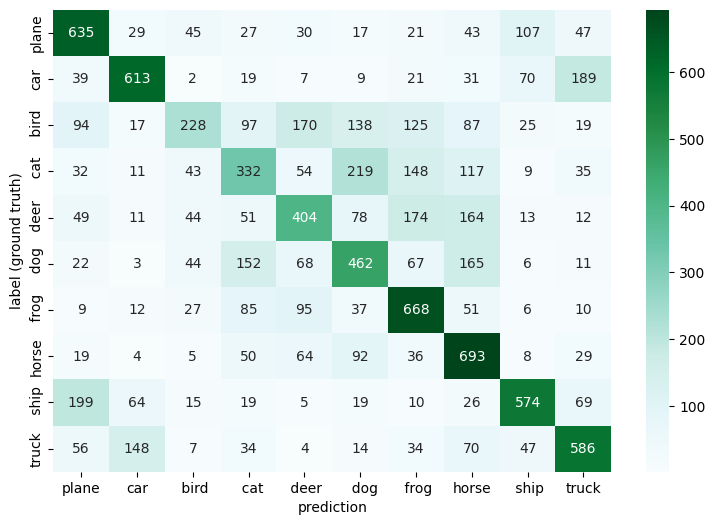

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['plane', 'car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

Some multi-class performance report defined from Scikit-learn

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names))

              precision    recall  f1-score   support

       plane       0.55      0.63      0.59      1001
         car       0.67      0.61      0.64      1000
        bird       0.50      0.23      0.31      1000
         cat       0.38      0.33      0.36      1000
        deer       0.45      0.40      0.43      1000
         dog       0.43      0.46      0.44      1000
        frog       0.51      0.67      0.58      1000
       horse       0.48      0.69      0.57      1000
        ship       0.66      0.57      0.62      1000
       truck       0.58      0.59      0.58      1000

    accuracy                           0.52     10001
   macro avg       0.52      0.52      0.51     10001
weighted avg       0.52      0.52      0.51     10001

